# Parsing Table Data into Graphs

In [1]:
import pandas as pd

df1 = pd.read_csv('data/activity_list.csv')
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic
0,1,A,2,4,6
1,2,B,3,5,9
2,3,C,4,5,7
3,4,D,4,6,10
4,5,E,4,5,7


In [2]:
df1['Expected'] = round((df1['Optimistic'] + 4*df1['Normal'] + df1['Pessimistic']) / 6.0, 2)
df1.head()

,ID,Activity,Optimistic,Normal,Pessimistic,Expected
0,1,A,2,4,6,4.00
1,2,B,3,5,9,5.33
2,3,C,4,5,7,5.17
3,4,D,4,6,10,6.33
4,5,E,4,5,7,5.17


In [3]:
df2 = pd.read_csv('data/edge_list.csv')
df2.head()

,ID,Parent,Child
0,1,1,3
1,2,1,4
2,3,2,5
3,4,3,5
4,5,4,6


In [4]:
import networkx as nx

G = nx.DiGraph()

for index, row in df1.iterrows():
    G.add_node(row['Activity'])
    G.node[row['Activity']]['Optimistic'] = row['Optimistic']
    G.node[row['Activity']]['Normal'] = row['Normal']
    G.node[row['Activity']]['Pessimistic'] = row['Pessimistic']
    G.node[row['Activity']]['Expected'] = row['Expected']
    G.node[row['Activity']]['Type'] = 'normal'
    
dict(G.nodes(data=True))

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Type': 'normal'},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.33,
  'Type': 'normal'},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal'},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.33,
  'Type': 'normal'},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal'},
 'F': {'Optimistic': 3,
  'Normal': 4,
  'Pessimistic': 8,
  'Expected': 4.5,
  'Type': 'normal'},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.17,
  'Type': 'normal'}}

In [5]:
for index, row in df2.iterrows():
    u = df1.at[row['Parent']-1, 'Activity']
    v = df1.at[row['Child']-1, 'Activity']
    G.add_edge(u, v)
    
G.edges()

OutEdgeView([('A', 'C'), ('A', 'D'), ('B', 'E'), ('C', 'E'), ('D', 'F'), ('E', 'G')])

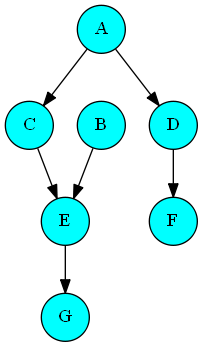

In [6]:
import networkx.drawing.nx_pydot as pdt
from IPython.display import Image, display

def display_graph(G, normal=['cyan', 'black'], critical=['red', 'white']):
    A = pdt.to_pydot(G)
    for i, node in enumerate(A.get_nodes()):
        node.set_shape('circle')
        node.set_style('filled')
        if 'fillcolor' not in node.get_attributes().keys():
            if node.get_attributes()['Type'] == 'normal':
                node.set_fillcolor(normal[0])
            else:
                node.set_fillcolor(critical[0])
        if 'fontcolor' not in node.get_attributes().keys():
            if node.get_attributes()['Type'] == 'normal':
                node.set_fontcolor(normal[1])
            else:
                node.set_fontcolor(critical[1])
    plt = Image(A.create_png())
    display(plt)
    
display_graph(G)

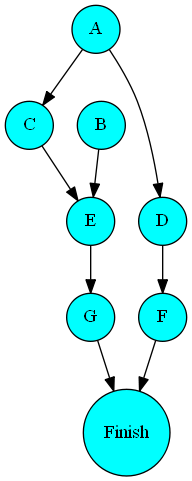

In [7]:
def add_finish_node(G, leaf_nodes=None):
    if G.has_node('Finish'):
        G.remove_node('Finish')
    if leaf_nodes is None:
        leaf_nodes = [node for node in G.nodes() if not list(G.successors(node))]
    G.add_node('Finish')
    G.node['Finish']['Optimistic'] = 0
    G.node['Finish']['Normal'] = 0
    G.node['Finish']['Pessimistic'] = 0
    G.node['Finish']['Expected'] = 0
    G.node['Finish']['Type'] = 'normal'
    for node in leaf_nodes:
        G.add_edge(node, 'Finish')
    return G
        
G = add_finish_node(G)
display_graph(G)

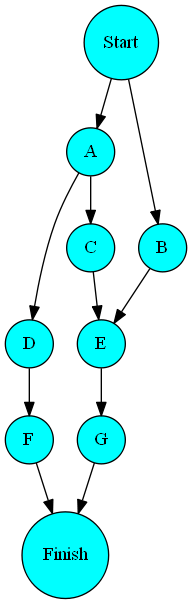

In [8]:
def add_start_node(G, finish_node='Finish'):
    if G.has_node('Start'):
        G.remove_node('Start')
    root_nodes = [node for node in nx.ancestors(G, finish_node) if not list(G.predecessors(node))]
    G.add_node('Start')
    G.node['Start']['Optimistic'] = 0
    G.node['Start']['Normal'] = 0
    G.node['Start']['Pessimistic'] = 0
    G.node['Start']['Expected'] = 0
    G.node['Start']['Type'] = 'normal'
    for node in root_nodes:
        G.add_edge('Start', node)
    return G

G = add_start_node(G)
display_graph(G)

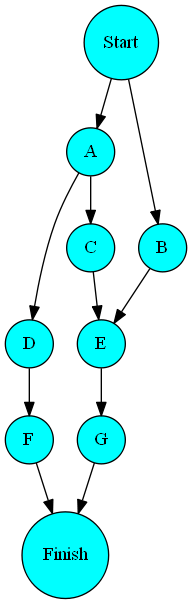

In [9]:
def create_subgraph(G):
    nodes = [node for node in nx.ancestors(G, 'Finish') if node in nx.descendants(G, 'Start')]
    nodes.extend(['Start', 'Finish'])
    return G.subgraph(nodes)
    
H = create_subgraph(G)    
display_graph(H)

In [10]:
for node in nx.topological_sort(H):
    parents = list(H.predecessors(node))
    if not parents:
        H.node[node]['ES'] = 0
    else:
        H.node[node]['ES'] = max(H.node[x]['EF'] for x in parents)
    H.node[node]['EF'] = round(H.node[node]['ES'] + H.node[node]['Expected'], 2)
    
dict(H.nodes(data=True))  

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Type': 'normal',
  'ES': 0,
  'EF': 4.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.33,
  'Type': 'normal',
  'ES': 0,
  'EF': 5.33},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal',
  'ES': 4.0,
  'EF': 9.17},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.33,
  'Type': 'normal',
  'ES': 4.0,
  'EF': 10.33},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal',
  'ES': 9.17,
  'EF': 14.34},
 'F': {'Optimistic': 3,
  'Normal': 4,
  'Pessimistic': 8,
  'Expected': 4.5,
  'Type': 'normal',
  'ES': 10.33,
  'EF': 14.83},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expected': 5.17,
  'Type': 'normal',
  'ES': 14.34,
  'EF': 19.51},
 'Finish': {'Optimistic': 0,
  'Normal': 0,
  'Pessimistic': 0,
  'Expected': 0,
  'Type': 'normal',
  'ES':

In [11]:
for node in list(reversed(list(nx.topological_sort(H)))):
    children = list(H.successors(node))
    if not children:
        H.node[node]['LF'] = H.node[node]['EF']
    else:
        H.node[node]['LF'] = min(H.node[x]['LS'] for x in children)
    H.node[node]['LS'] = round(H.node[node]['LF'] - H.node[node]['Expected'], 2)
    
dict(H.nodes(data=True))

{'A': {'Optimistic': 2,
  'Normal': 4,
  'Pessimistic': 6,
  'Expected': 4.0,
  'Type': 'normal',
  'ES': 0,
  'EF': 4.0,
  'LF': 4.0,
  'LS': 0.0},
 'B': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 9,
  'Expected': 5.33,
  'Type': 'normal',
  'ES': 0,
  'EF': 5.33,
  'LF': 9.17,
  'LS': 3.84},
 'C': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal',
  'ES': 4.0,
  'EF': 9.17,
  'LF': 9.17,
  'LS': 4.0},
 'D': {'Optimistic': 4,
  'Normal': 6,
  'Pessimistic': 10,
  'Expected': 6.33,
  'Type': 'normal',
  'ES': 4.0,
  'EF': 10.33,
  'LF': 15.01,
  'LS': 8.68},
 'E': {'Optimistic': 4,
  'Normal': 5,
  'Pessimistic': 7,
  'Expected': 5.17,
  'Type': 'normal',
  'ES': 9.17,
  'EF': 14.34,
  'LF': 14.34,
  'LS': 9.17},
 'F': {'Optimistic': 3,
  'Normal': 4,
  'Pessimistic': 8,
  'Expected': 4.5,
  'Type': 'normal',
  'ES': 10.33,
  'EF': 14.83,
  'LF': 19.51,
  'LS': 15.01},
 'G': {'Optimistic': 3,
  'Normal': 5,
  'Pessimistic': 8,
  'Expecte

In [12]:
for node in H.nodes():
    H.node[node]['Slack'] = round(H.node[node]['LF'] - H.node[node]['EF'], 2)
    
[node for node in nx.topological_sort(H) if H.node[node]['Slack'] == 0]

['Start', 'A', 'C', 'E', 'G', 'Finish']

In [13]:
max(nx.all_simple_paths(H, source='Start', target='Finish'), key=lambda path: sum(H.node[node]['Expected'] for node in path))

['Start', 'A', 'C', 'E', 'G', 'Finish']

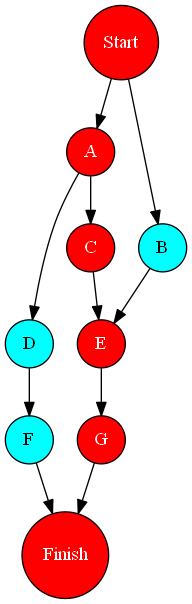

In [14]:
def critical_path(H, src='Start', dest='Finish'):
    path_duration = lambda path: sum(H.node[node]['EF'] - H.node[node]['ES'] for node in path)
    return max(nx.all_simple_paths(H, source='Start', target='Finish'), key=path_duration)

def highlight_critical_path(H, src='Start', dest='Finish', fillcolor='red', fontcolor='white'):
    for node in H.nodes():
        if node in critical_path(H, src=src, dest=dest):
            H.node[node]['Type'] = 'critical'
        else:
            H.node[node]['Type'] = 'normal'
    return H

H = highlight_critical_path(H)
display_graph(H)

In [15]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py
from IPython.display import display
from datetime import datetime, timedelta

def display_gantt_chart(G, start='ES', finish='EF', begin=None, colors=None, reverse_colors=False,
                        index_col=None, show_colorbar=False, title='Gantt Chart', bar_width=0.2,
                        showgrid_x=True, showgrid_y=True):
    if begin is None:
        begin = datetime.now().date()
    else:
        begin = datetime.strptime(begin, '%Y-%m-%d').date()
    df = [dict(Task   = node,
               Start  = str(begin + timedelta(days=G.node[node][start])),
               Finish = str(begin + timedelta(G.node[node][finish])),
               Type   = G.node[node]['Type'])
          for node in list(reversed(list(nx.topological_sort(G))))]
    fig = ff.create_gantt(df, colors=colors, reverse_colors=reverse_colors, index_col=index_col,
                          show_colorbar=show_colorbar, title=title, bar_width=bar_width,
                          showgrid_x=showgrid_x, showgrid_y=showgrid_y)
    f = go.FigureWidget(fig)
    display(f)


colors = {'normal': 'rgb(117, 218, 255)',
          'critical': 'rgb(255, 0, 0)'}
display_gantt_chart(H, colors=colors, index_col='Type', show_colorbar=True)

FigureWidget({
    'data': [{'marker': {'color': 'white'},
              'name': '',
              'showlegend…

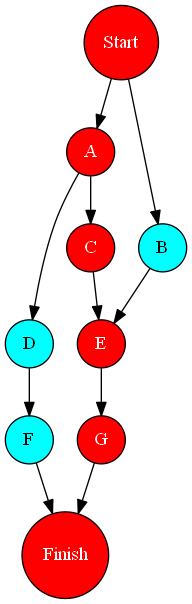

FigureWidget({
    'data': [{'marker': {'color': 'white'},
              'name': '',
              'type': 'sc…

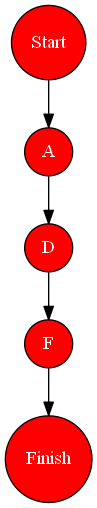

FigureWidget({
    'data': [{'marker': {'color': 'white'},
              'name': '',
              'type': 'sc…

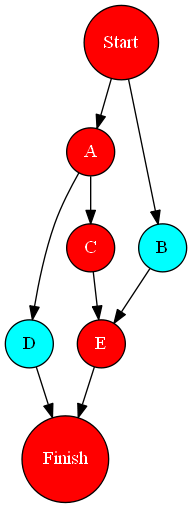

FigureWidget({
    'data': [{'marker': {'color': 'white'},
              'name': '',
              'type': 'sc…

In [16]:
import pandas as pd
import networkx as nx
import networkx.drawing.nx_pydot as pdt
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.offline as py
from IPython.display import Image, display
from datetime import datetime, timedelta
from collections import defaultdict

def read_files(activity_file, edge_file, header=['infer','infer'],
               id=[False,False], coeffs=[1,4,1], key=True):
    df1 = pd.read_csv(activity_file, header=header[0])
    df2 = pd.read_csv(edge_file, header=header[1])
    if id[0]:
        df1 = df1.drop(df1.columns[0], axis=1)
    if id[1]:
        df2 = df2.drop(df2.columns[0], axis=1)
    activity_dict = defaultdict(dict)
    for _, row in df1.iterrows():
        node = row.iloc[0]
        activity_dict[node]['Optimistic'] = row.iloc[1]
        activity_dict[node]['Normal'] = row.iloc[2]
        activity_dict[node]['Pessimistic'] = row.iloc[3]
        activity_dict[node]['Type'] = 'normal'
        activity_dict[node]['Expected'] = round((coeffs[0]*activity_dict[node]['Optimistic'] +\
                                                 coeffs[1]*activity_dict[node]['Normal'] +\
                                                 coeffs[2]*activity_dict[node]['Pessimistic'])\
                                                 / float(sum(coeffs)), 2)
    edge_list = []
    if key:
        for _, row in df2.iterrows():
            u = df1.iloc[row.iloc[0]-1, 0]
            v = df1.iloc[row.iloc[1]-1, 0]
            edge_list.append((u, v))
    else:
        for _, row in df2.iterrows():
            u = row.iloc[0]
            v = row.iloc[1]
            edge_list.append((u, v))
    return activity_dict, edge_list

def parse_graph(activities, edges, title='Project X', begin=None, deadline=None):
    G = nx.DiGraph()
    G.graph['Title'] = title
    G.graph['Begin'] = str(datetime.now().date()) if begin is None else begin
    G.graph['Deadline'] = deadline
    if isinstance(activities, dict):
        G.add_nodes_from(activities.items())
    else:
        G.add_nodes_from(activities)
    G.add_edges_from(edges)
    return G
    
def display_graph(G, normal=['cyan', 'black'], critical=['red', 'white']):
    A = pdt.to_pydot(G)
    for i, node in enumerate(A.get_nodes()):
        node.set_shape('circle')
        node.set_style('filled')
        if 'fillcolor' not in node.get_attributes().keys():
            if node.get_attributes()['Type'] == 'normal':
                node.set_fillcolor(normal[0])
            else:
                node.set_fillcolor(critical[0])
        if 'fontcolor' not in node.get_attributes().keys():
            if node.get_attributes()['Type'] == 'normal':
                node.set_fontcolor(normal[1])
            else:
                node.set_fontcolor(critical[1])
    plt = Image(A.create_png())
    display(plt)

def add_finish_node(G, leaf_nodes=None):
    if G.has_node('Finish'):
        G.remove_node('Finish')
    if leaf_nodes is None:
        leaf_nodes = [node for node in G.nodes() if not list(G.successors(node))]
    G.add_node('Finish')
    G.node['Finish']['Optimistic'] = 0
    G.node['Finish']['Normal'] = 0
    G.node['Finish']['Pessimistic'] = 0
    G.node['Finish']['Expected'] = 0
    G.node['Finish']['Type'] = 'normal'
    for node in leaf_nodes:
        G.add_edge(node, 'Finish')
    return G

def add_start_node(G, finish_node='Finish'):
    if G.has_node('Start'):
        G.remove_node('Start')
    root_nodes = [node for node in nx.ancestors(G, finish_node) if not list(G.predecessors(node))]
    G.add_node('Start')
    G.node['Start']['Optimistic'] = 0
    G.node['Start']['Normal'] = 0
    G.node['Start']['Pessimistic'] = 0
    G.node['Start']['Expected'] = 0
    G.node['Start']['Type'] = 'normal'
    for node in root_nodes:
        G.add_edge('Start', node)
    return G

def create_subgraph(G):
    nodes = [node for node in nx.ancestors(G, 'Finish') if node in nx.descendants(G, 'Start')]
    nodes.extend(['Start', 'Finish'])
    return G.subgraph(nodes)

def init_graph(H, duration='Expected'):
    # Calculate Early Start and Early Finish
    for node in nx.topological_sort(H):
        parents = list(H.predecessors(node))
        if not parents:
            H.node[node]['ES'] = 0
        else:
            H.node[node]['ES'] = max(H.node[x]['EF'] for x in parents)
        H.node[node]['EF'] = round(H.node[node]['ES'] + H.node[node][duration], 2)
    # Calculate Late Start and Late Finish
    for node in list(reversed(list(nx.topological_sort(H)))):
        children = list(H.successors(node))
        if not children:
            H.node[node]['LF'] = H.node[node]['EF']
        else:
            H.node[node]['LF'] = min(H.node[x]['LS'] for x in children)
        H.node[node]['LS'] = round(H.node[node]['LF'] - H.node[node][duration], 2)
    # Calculate Slack
    for node in H.nodes():
        H.node[node]['Slack'] = round(H.node[node]['LF'] - H.node[node]['EF'], 2)
    return H
        
def highlight_critical_path(H, src='Start', dest='Finish', fillcolor='red', fontcolor='white'):
    for node in H.nodes():
        if node in critical_path(H, src=src, dest=dest):
            H.node[node]['Type'] = 'critical'
        else:
            H.node[node]['Type'] = 'normal'
    return H
        
def critical_path(H, src='Start', dest='Finish'):
    path_duration = lambda path: sum(H.node[node]['EF'] - H.node[node]['ES'] for node in path)
    return max(nx.all_simple_paths(H, source='Start', target='Finish'), key=path_duration)

def display_gantt_chart(G, start='ES', finish='EF', begin=None, colors=None, reverse_colors=False,
                        index_col=None, show_colorbar=False, title=None, bar_width=0.2,
                        showgrid_x=True, showgrid_y=True):
    if begin is None:
        begin = G.graph['Begin']
    begin = datetime.strptime(begin, '%Y-%m-%d').date()
    if title is None:
        title = G.graph['Title']
    df = [dict(Task   = node,
               Start  = str(begin + timedelta(days=G.node[node][start])),
               Finish = str(begin + timedelta(G.node[node][finish])),
               Type   = G.node[node]['Type'])
          for node in list(reversed(list(nx.topological_sort(G))))]
    fig = ff.create_gantt(df, colors=colors, reverse_colors=reverse_colors, index_col=index_col,
                          show_colorbar=show_colorbar, title=title, bar_width=bar_width,
                          showgrid_x=showgrid_x, showgrid_y=showgrid_y)
    f = go.FigureWidget(fig)
    display(f)
    
def PERT(G, leaf_nodes=None, duration='Expected'):
    G = add_finish_node(G, leaf_nodes=leaf_nodes)
    G = add_start_node(G)
    H = create_subgraph(G)
    H = init_graph(H, duration=duration)
    H = highlight_critical_path(H)
    return H

if __name__ == '__main__':
    
    activities, edges = read_files('data/activity_list.csv', 'data/edge_list.csv', id=[True, True])
    G = parse_graph(activities, edges)

    H = PERT(G)
    display_graph(G)
    display_gantt_chart(G)
    
    I = PERT(G, leaf_nodes=['F'])
    display_graph(I)
    display_gantt_chart(I, index_col='Type', show_colorbar=True)
    
    J = PERT(G, leaf_nodes=['E', 'D'])
    display_graph(J)
    display_gantt_chart(J)